In [43]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import gymnasium as gym
import torch
from torch import nn
from torch import optim
from torchsummary import summary
import seaborn as sns
sns.set()

## Helper Functions

In [2]:
def create_minibatches(batch_size, *arrays):
    n = len(arrays[0]) # assume all arrays have same length
    assert all(len(arr) == n for arr in arrays), "All input arrays must have the same length"


    # shuffle indices
    indices = np.random.permutation(n)
    shuffled_arrays = [arr[indices] for arr in arrays]

    for start_ind in range(0, n, batch_size):
        end_ind = min(start_ind + batch_size, n)
        yield tuple(arr[start_ind:end_ind] for arr in shuffled_arrays)


In [3]:
def random_rollout(env, device):
    state, _ = env.reset()
    terminated, truncated = False, False

    states_actions = []

    while not terminated and not truncated:
        # if len(states_actions) >= 5: break

        action = env.action_space.sample()
        next_state, _, terminated, truncated, _ = env.step(action)

        state = state[:2]
        states_actions.append(np.concatenate((state, action)))

        state = next_state
    
    states_actions = torch.FloatTensor(np.array(states_actions))

    return states_actions

In [4]:
def collect_samples(env, n_iter):
    states_actions = []

    # Collect Data
    for i in range(n_iter):
        states_actions.append(random_rollout(env, "cpu"))

    states_actions = torch.stack(states_actions)

    return states_actions

In [5]:
def plot_feature_trajectory(ax, feature, title, n_iter, horizon, color="blue", plot_individual=True):
    if plot_individual:
        for i in range(n_iter):
            ax.plot(feature[i, :], alpha = 0.1, color="gray")
    
    avg = torch.mean(feature, dim=0)
    std = torch.std(feature, axis=0)
    ax.plot(avg, color=color, label=title + " mean")
    ax.fill_between(
        np.arange(horizon),
        avg - std,
        avg + std,
        color=color, alpha=0.3,
        label=title + '± 1 Std Dev'
    )
    ax.legend(loc="upper left")

In [6]:
# initialize environment
env = gym.make("Pendulum-v1", render_mode=None)
obs_space_size = env.observation_space.shape[0]
action_space_size = env.action_space.shape[0]

## RNN

In [7]:
class SimpleRNN(nn.Module):
    def __init__(self, obs_space_size, action_space_size, hidden_size):
        super().__init__()
        self.l0 = nn.Sequential(
            nn.Linear(obs_space_size + action_space_size, 32),
            nn.ReLU()
        )
        
        self.rnn = nn.RNN(32, hidden_size, batch_first=True)

        self.l1 = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, obs_space_size),
        )
        self.hidden_size = hidden_size

    def forward(self, x, h0=None):
        if h0 is None:
            h0 = torch.zeros(1, x.size(0), self.hidden_size)

        out = self.l0(x)
        out, ht = self.rnn(out, h0)
        out = self.l1(out)
        return out, ht

In [8]:
def get_sequences_from_data(data, sequence_length):
    output = []

    for i in range(len(data) - sequence_length + 1):

        sequence = data[i: i + sequence_length]
        output.append(sequence)
    
    output = torch.stack(output, dim=0)

    return output

get_sequences_from_data(torch.FloatTensor([1, 2, 3, 4, 5]), 2) # test

tensor([[1., 2.],
        [2., 3.],
        [3., 4.],
        [4., 5.]])

In [9]:
def train_rnn(env, model, num_epochs, num_episodes, sequence_length, batch_size, lr, device, multistep=False):
    losses = []
    loss_fn = nn.MSELoss()

    opt = optim.Adam(model.parameters(), lr=lr)

    # Collect Data
    t0_states_actions = [[] for i in range(num_episodes)]
    t1_actions = [[] for i in range(num_episodes)]
    t1_states = [[] for i in range(num_episodes)] # for testing
    t2_states = [[] for i in range(num_episodes)]
    
    for i in range(num_episodes):
        with torch.no_grad():
            states_actions = random_rollout(env, device)

            t0_states_actions[i] = states_actions[:-2,]
            t1_actions[i] = states_actions[1:-1, 2].unsqueeze(dim=1)
            t1_states[i] = states_actions[1:-1, :2]
            t2_states[i] = states_actions[2:, :2]

            t0_states_actions[i] = get_sequences_from_data(t0_states_actions[i], sequence_length)
            t1_actions[i] = get_sequences_from_data(t1_actions[i], sequence_length)
            t1_states[i] = get_sequences_from_data(t1_states[i], sequence_length)
            t2_states[i] = get_sequences_from_data(t2_states[i], sequence_length)
    
    t0_states_actions = torch.concatenate(t0_states_actions)
    t1_actions = torch.concatenate(t1_actions)
    t1_states = torch.concatenate(t1_states)
    t2_states = torch.concatenate(t2_states)

    # print(t0_states_actions.shape)
    # print(t1_states.shape)

    # Train Model
    for epoch in range(num_epochs):

        for b_t0_states_actions, b_t1_actions, b_t1_states, b_t2_states in create_minibatches(batch_size, t0_states_actions, t1_actions, t1_states, t2_states):
            noise = torch.randn(b_t0_states_actions.shape) * 0.005 # Add noise to states
            noise[:,:,2] = 0 # Remove noise from actions

            t1_predicted_states, _ = model(b_t0_states_actions) # ignore hidden space ht
            model_loss = loss_fn(t1_predicted_states, b_t1_states)

            if multistep:
                next_state_actions = torch.cat((b_t1_actions, t1_predicted_states), dim=2)
                t2_predicted_states, _ = model(next_state_actions)
                model_loss += loss_fn(t2_predicted_states, b_t2_states)
                
            opt.zero_grad()
            model_loss.backward()
            opt.step()

            losses.append(model_loss.item())

    return losses

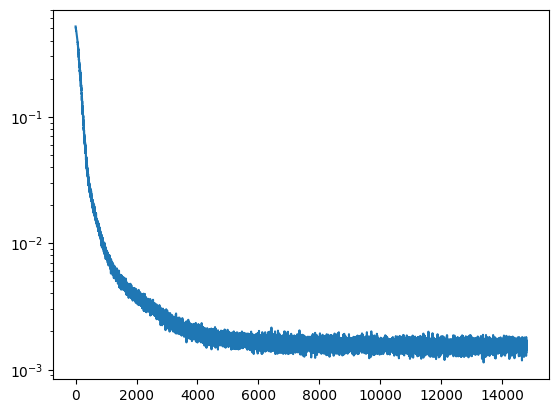

In [10]:
rnn_model = SimpleRNN(obs_space_size-1, action_space_size, hidden_size=64) # omit velocity
losses = train_rnn(env, rnn_model, num_epochs=100, num_episodes=200, sequence_length=10, batch_size=256, lr=1e-4, device="cpu", multistep=False) # multistep no work
plt.plot(losses)
plt.yscale("log")

## Test RNN

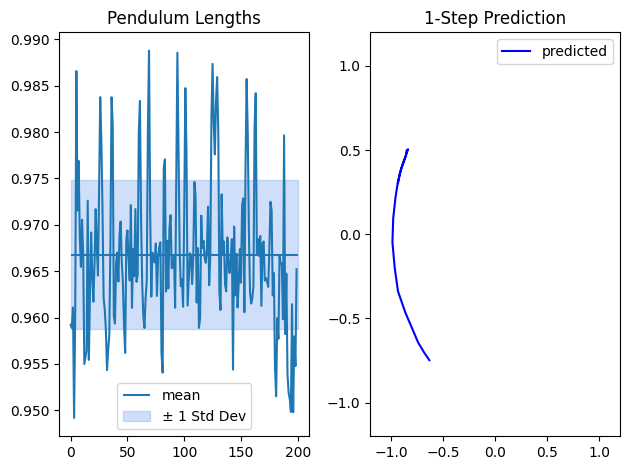

In [11]:
"""
1 step prediction, empty hidden state every time
"""

with torch.no_grad():
    states_actions = random_rollout(env, device="cpu")
    states_actions = get_sequences_from_data(states_actions, 1)
    next_state_predictions, _ = rnn_model(states_actions)

# next_state_predictions = next_state_predictions[0]
# next_state_predictions.shape

x = next_state_predictions[:,0,0]
y = next_state_predictions[:,0,1]

lengths = x ** 2 + y ** 2
lengths_mean = lengths.mean()
lengths_std = lengths.std()

fig, axs = plt.subplots(1, 2)
axs[0].plot(lengths)
axs[0].hlines(lengths_mean, 0, 200, label="mean")
axs[0].fill_between((0, 200), lengths_mean - lengths_std, lengths_mean + lengths_std, color='cornflowerblue', alpha=0.3, label='± 1 Std Dev')
axs[0].set_title("Pendulum Lengths")
axs[0].legend()

horizon = 20
axs[1].plot(x[:horizon], y[:horizon], color="blue", label="predicted")
axs[1].set_title("1-Step Prediction")
axs[1].legend(loc="upper right")
axs[1].set_ylim(-1.2, 1.2)
axs[1].set_xlim(-1.2, 1.2)

fig.tight_layout()

In [12]:
def rnn_rollout(model, n_iter, horizon, states_actions=None):

    # Collect Data
    if states_actions is None:
        states_actions = collect_samples(env, n_iter)

    # Start with same start states
    input = states_actions[:,0,:]
    ht = None

    # Predict Trajectories
    preds = []
    for i in range(horizon):
        input = input.reshape(n_iter, 1, 3) # Sequences of 1

        with torch.no_grad():
            pred, ht = model(input, ht) # carry over hidden state
    
        input = torch.concatenate((pred, states_actions[:, i, 2].reshape(n_iter, 1, 1)), dim=2)
        preds.append(pred)

    preds = torch.stack(preds).transpose(0, 1).squeeze(dim=2) # dim 2 is the sequence

    return preds, states_actions
       

In [13]:
n_iter = 150
horizon = 199
preds, states_actions = rnn_rollout(rnn_model, n_iter, horizon)

print(f"{preds.shape = }")
print(f"{states_actions.shape = }")

preds.shape = torch.Size([150, 199, 2])
states_actions.shape = torch.Size([150, 200, 3])


Text(0, 0.5, 'y')

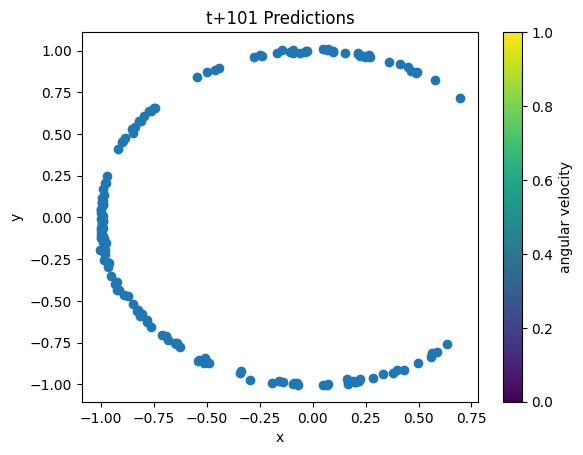

In [14]:
n = 100
sc = plt.scatter(preds[:,n,0], preds[:,n,1])
plt.colorbar(sc, label="angular velocity")
plt.title(f"t+{n+1} Predictions")
plt.xlabel("x")
plt.ylabel("y")

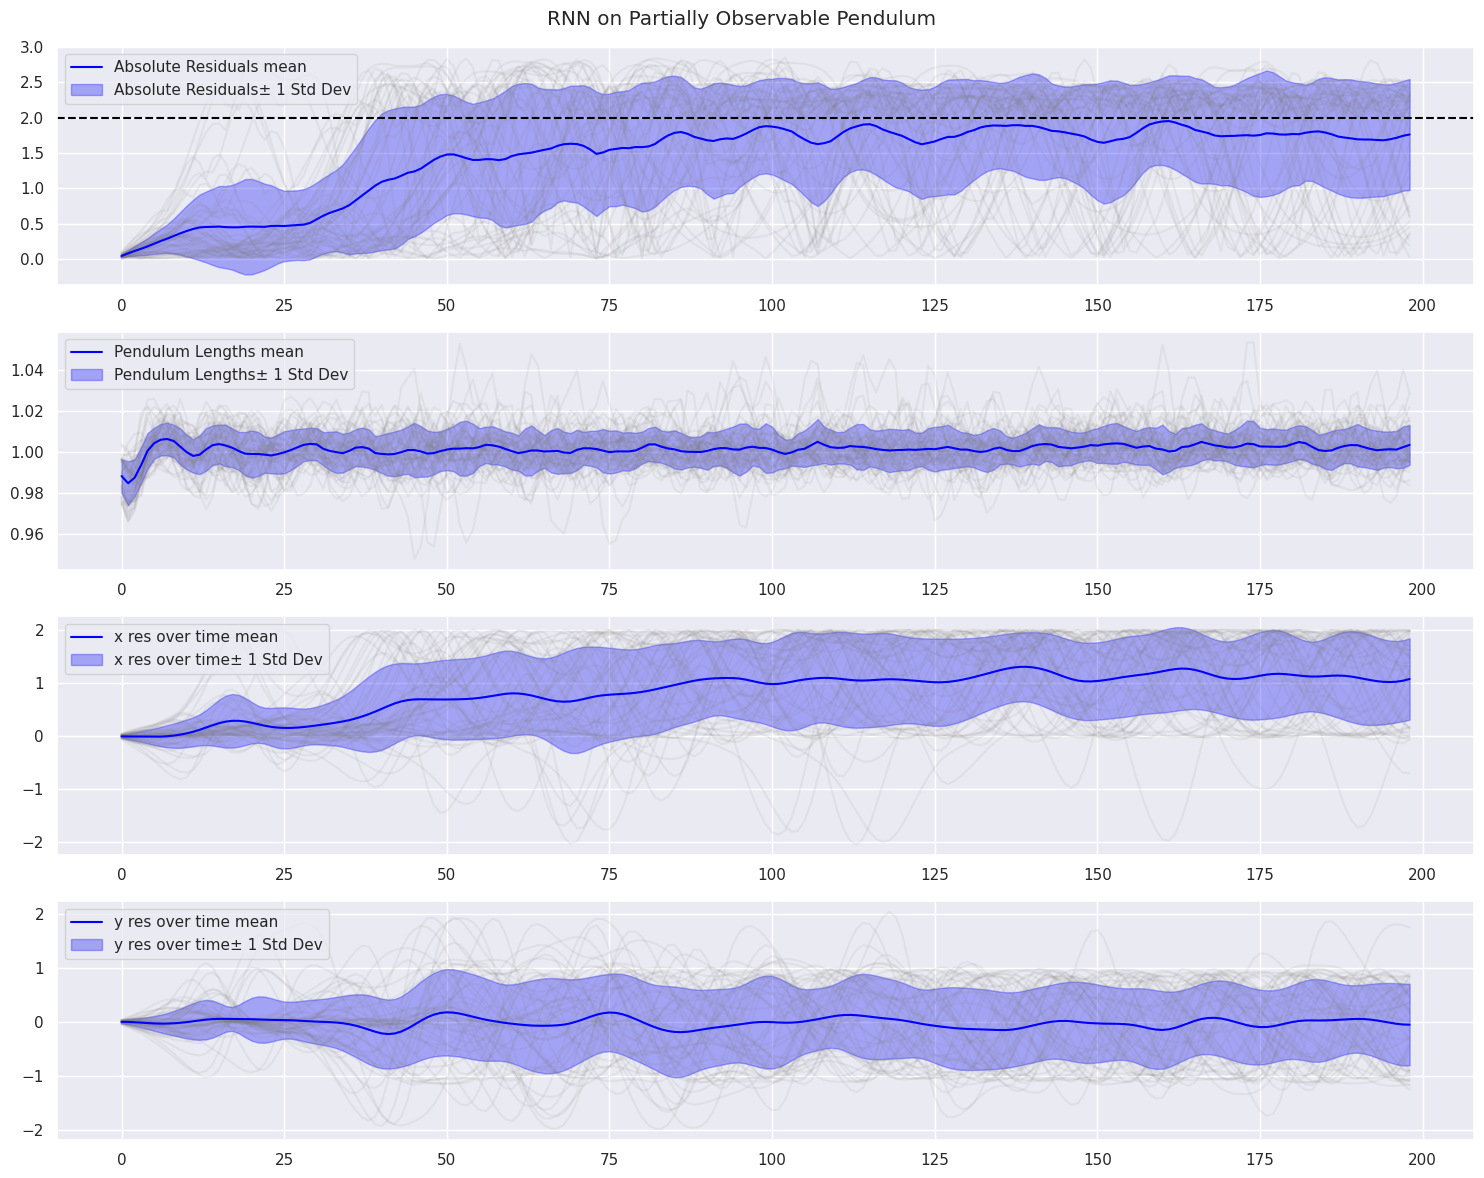

In [44]:
# Plot Data
fig, axs = plt.subplots(4, 1, figsize=(15, 12))

lengths = torch.sqrt(preds[:, :, 0] ** 2 + preds[:, :, 1] ** 2)
residuals = states_actions[:, 1:horizon + 1, :2] - preds
sum_residuals = residuals.abs().sum(dim=2)

fig.suptitle("RNN on Partially Observable Pendulum")

plot_feature_trajectory(axs[0], sum_residuals, "Absolute Residuals", n_iter, horizon)
axs[0].axhline(2, c="black", linestyle="dashed") # Dummy Line
plot_feature_trajectory(axs[1], lengths, "Pendulum Lengths", n_iter, horizon)
plot_feature_trajectory(axs[2], residuals[:, :, 0], "x res over time", n_iter, horizon)
plot_feature_trajectory(axs[3], residuals[:, :, 1], "y res over time", n_iter, horizon)

fig.tight_layout()

## NCPS

In [19]:
from ncps.wirings import NCP
from ncps.torch import CfC


def load_ncps(num_rollouts):

    PATH = f"models/model_{num_rollouts}.pt"
    out_features = 2
    in_features = 3
    command_neurons = 6
    
    #wiring = AutoNCP(6, out_features)  
    wiring = NCP(inter_neurons=5, command_neurons=command_neurons, motor_neurons=out_features,
                 sensory_fanout=5, inter_fanout=command_neurons, recurrent_command_synapses=command_neurons, motor_fanin=2)
    
    NCPS = CfC(in_features, wiring, batch_first=True, return_sequences=False, activation = "tanh", mixed_memory=True)
    NCPS = torch.load(PATH)
    NCPS.eval()


    return NCPS

num_episode = 50
ncps_model = load_ncps(num_episode)

/tmp/ipykernel_666669/1819526972.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  NCPS = torch.load(PATH)


In [20]:
states_actions = collect_samples(env, 1)
input = states_actions[0].reshape(-1, 1, 3)
print(input.shape)

ncps_model(input)[0].shape

torch.Size([200, 1, 3])


torch.Size([200, 2])

In [57]:
def ncps_rollout(model, n_iter, horizon, states_actions=None):

    # Collect Data
    if states_actions is None:
        states_actions = collect_samples(env, n_iter)

    # Start with same start states
    input = states_actions[:,0,:]
    print(input.shape)
    ht = None

    # Predict Trajectories
    preds = []
    for i in range(horizon):
        input = input.reshape(n_iter, 1, 3)

        with torch.no_grad():
            pred, ht = model(input, ht)

        input = torch.concatenate((pred.reshape(n_iter, 1, 2), states_actions[:, i, 2].reshape(n_iter, 1, 1)), dim=2)
        preds.append(pred)

    preds = torch.stack(preds).transpose(0, 1).squeeze(dim=2) # dim 2 is the sequence

    return preds, states_actions

n_iter = 150
horizon = 199
preds, states_actions = ncps_rollout(ncps_model, n_iter, horizon)

print(f"{preds.shape = }")
print(f"{states_actions.shape = }")

torch.Size([150, 3])
preds.shape = torch.Size([150, 199, 2])
states_actions.shape = torch.Size([150, 200, 3])


## Random Helper Functions

In [58]:
angular_velocity = 2
max_angular_velocity_magnitude = 8
def get_rnd_env_samples(env, num_rollouts, scale_vel = True):
    
    t_obs = []
    t_a = []
    t_n_obs = []
    for _ in range(num_rollouts):
        
        observation, info = env.reset()
        
        terminated = False
        truncated = False
    
        c_obs = []
        c_a = []
        c_n_obs = []
        
        while not (terminated or truncated):
            # Get the action from the trained PPO agent
            #vect_obs = t.tensor(observation, dtype=t.float32, device='cpu')
            obs = observation
            v_obs = torch.FloatTensor(observation)
    
            action = env.action_space.sample()
        
            # Take a step in the environment
            observation, reward, terminated, truncated, info = env.step(action)
            
            c_obs.append(obs)
            c_a.append(action)
            c_n_obs.append(observation)
       
        # Once the episode is done, close the environment
        #env.close()
    
        t_obs.append(np.vstack(c_obs))
        t_a.append(np.vstack(c_a))
        t_n_obs.append(np.vstack(c_n_obs))
    
    env.close()
    
    t_obs = np.stack(t_obs)
    t_a = np.stack(t_a)
    t_n_obs = np.stack(t_n_obs)
    
    #t_obs.shape
    #t_a.shape
    if scale_vel == True:
        t_obs[:, :, angular_velocity] = t_obs[:, :, angular_velocity]/max_angular_velocity_magnitude
        t_n_obs[:, :, angular_velocity] = t_n_obs[:, :, angular_velocity]/max_angular_velocity_magnitude
    
    #inputs = np.concatenate((t_obs, t_a), axis=2)

    return t_obs, t_a, t_n_obs

In [59]:
t_inputs, t_a, t_outputs = get_rnd_env_samples(env, 50)
t_inputs = t_inputs[:, :, 0:2]
t_outputs = t_outputs[:, :, 0:2]
t_inputs = np.concatenate((t_inputs, t_a), axis=-1)
t_inputs.shape

(50, 200, 3)

## Sample Efficiencey

In [22]:
num_episodes = [50, 100, 200]

# Hyperparameters
lr = 1e-4
batch_size = 256
num_epochs = 200
sequence_length = 10 # rnn only

### RNN

In [23]:
rnn_models = []
rnn_losses = []

for num_episode in num_episodes:

    # RNN
    rnn_models.append(SimpleRNN(obs_space_size-1, action_space_size, hidden_size=64)) # -1 to omit velocity
    rnn_losses.append(train_rnn(env, rnn_models[-1], num_epochs, num_episode, sequence_length, batch_size, lr, device="cpu"))

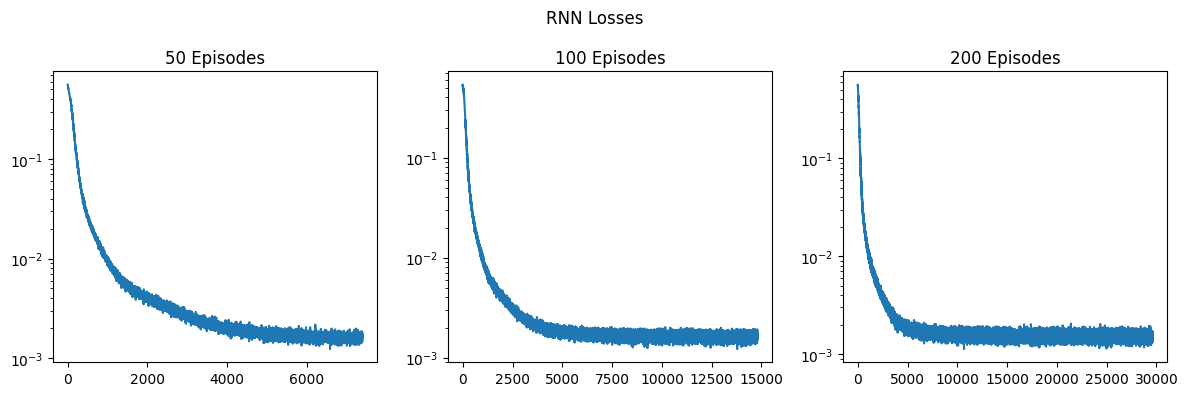

In [24]:
def plot_losses(losses, num_episodes, suptitle):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    for i in range(len(num_episodes)):
        axs[i].plot(losses[i])
        axs[i].set_title(f"{num_episodes[i]} Episodes")
        axs[i].set_yscale("log")
    fig.suptitle(suptitle)
    fig.tight_layout()

plot_losses(rnn_losses, num_episodes, "RNN Losses")

In [54]:
n_iter = 150
horizon = 199
states_actions = collect_samples(env, n_iter)

rnn_preds = []
rnn_sum_residuals = []
for i in range(len(num_episodes)):
    preds, states_actions = rnn_rollout(rnn_models[i], n_iter, horizon, states_actions)
    rnn_preds.append(preds)

    residuals = states_actions[:, 1:horizon + 1, :2] - preds
    rnn_sum_residuals.append(residuals.abs().sum(dim=2))


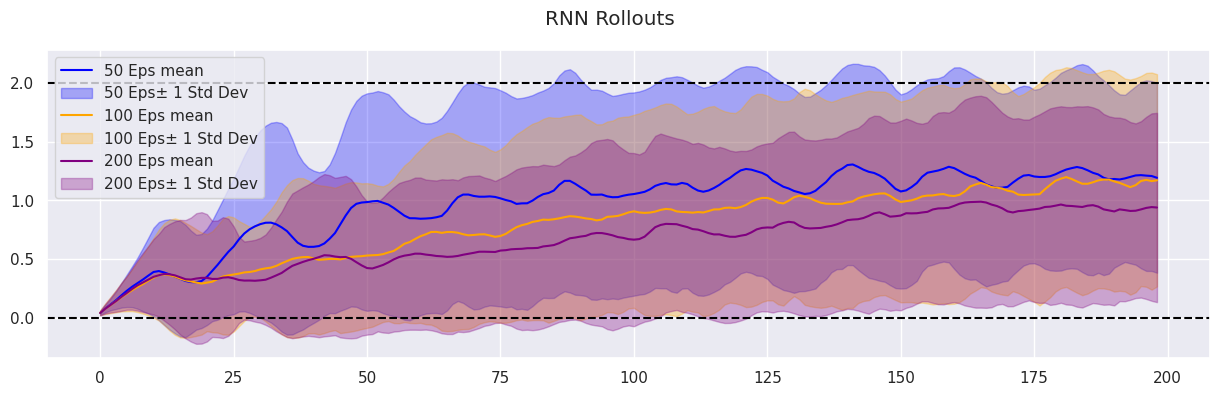

In [55]:
# Plot Rollouts
fig, axs = plt.subplots(1, 1, figsize=(15, 4))
fig.suptitle("RNN Rollouts")

colors = ["blue", "orange", "purple"]

for i in range(len(num_episodes)):
    plot_feature_trajectory(axs, rnn_sum_residuals[i], f"{num_episodes[i]} Eps", n_iter, horizon, colors[i], False)
axs.axhline(2, c="black", linestyle="dashed") # Dummy Line
axs.axhline(0, c="black", linestyle="dashed") # 0 Line

### NCP

In [27]:
ncps_models = []

for num_episode in num_episodes:
    ncps_models.append(load_ncps(num_episode))

/tmp/ipykernel_666669/1819526972.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  NCPS = torch.load(PATH)


In [78]:
def n_step_rollouts(ncps_model):
    n_step_rollout = 200
    window_size = 5  # the number of timesteps in each input window
    
    # Suppose t_inputs has shape (B, window_size, input_dim) for the initial burn-in.
    cur_input = torch.FloatTensor(t_inputs[:, :window_size, :])  # (B, 5, input_dim)
    
    # Suppose a has shape (B, n_step_rollout, a_dim),
    # meaning we have 'n_step_rollout' actions to apply in open-loop fashion.
    a = torch.FloatTensor(t_a)  # (B, 100, a_dim)
    
    # Prepare hidden state for CfC with mixed_memory
    h0 = torch.zeros((cur_input.shape[0], ncps_model.state_size), device=cur_input.device)
    c0 = torch.zeros((cur_input.shape[0], ncps_model.state_size), device=cur_input.device)
    hx = (h0, c0)
    
    predictions = []
    
    for i in range(n_step_rollout):
        # Forward pass the current 5 timesteps => shape (B, 5, input_dim)
        with torch.no_grad():
            out, hx = ncps_model(cur_input, hx)  
            # out => shape (B, hidden_dim), since return_sequences=False
    
        # Collect this step's output for inspection
        # shape => (B, 1, hidden_dim)
        predictions.append(out.unsqueeze(1))
    
        # Build the new last-timestep that will go into position '4' of the next window
        # (the 0th will be dropped).
        # out => (B, hidden_dim), a[:, i, :] => (B, a_dim)
        # So next_step_input => (B, hidden_dim + a_dim)
        next_step_input = torch.cat([out, a[:, i, :]], dim=-1)
    
        # next_step_input => (B, 1, hidden_dim + a_dim) so it can be appended
        next_step_input = next_step_input.unsqueeze(1)
    
        # Drop the oldest timestep (index 0) from cur_input => shape (B, 4, input_dim)
        # Then append the new step => shape (B, 5, input_dim)
        cur_input = torch.cat([cur_input[:, 1:, :], next_step_input], dim=1)
    
    # Finally, stack all predictions => (B, n_step_rollout, hidden_dim)
    predictions = torch.cat(predictions, dim=1).numpy()
    return predictions

ncps_sum_residuals = []
for i in range(3):
    model = ncps_models[i]
    preds = n_step_rollouts(model)
    NCPS_res = torch.tensor(preds - t_outputs[:, :, :2])
    NCPS_total_res = torch.sum(torch.abs(NCPS_res), axis=-1)
    ncps_sum_residuals.append(NCPS_total_res)

In [79]:
ncps_sum_residuals[0].shape

torch.Size([50, 200])

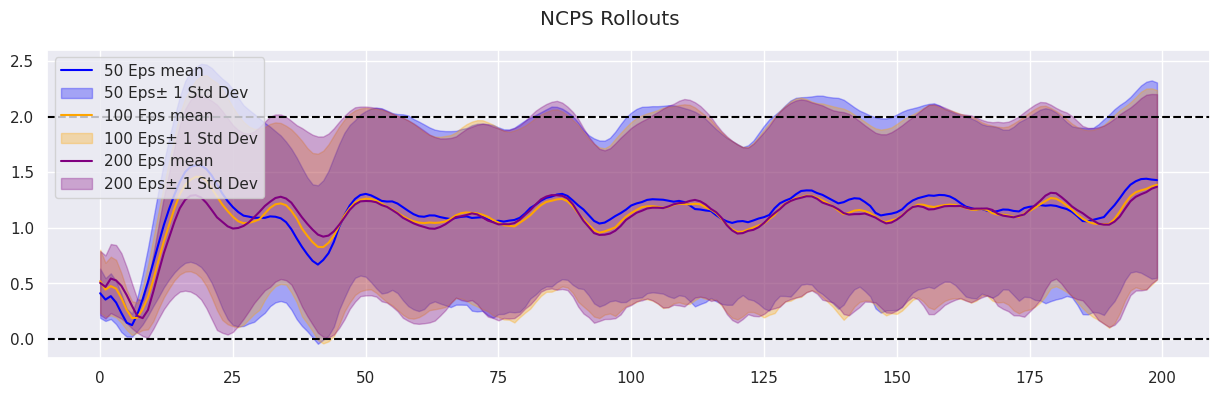

In [80]:
# Plot Rollouts
fig, axs = plt.subplots(1, 1, figsize=(15, 4))
fig.suptitle("NCPS Rollouts")

for i in range(len(num_episodes)):
    plot_feature_trajectory(axs, ncps_sum_residuals[i], f"{num_episodes[i]} Eps", n_iter, 200, colors[i], False)
axs.axhline(2, c="black", linestyle="dashed") # Dummy Line
axs.axhline(0, c="black", linestyle="dashed") # 0 Line

### Plot Together

In [81]:
def when_residuals_exceed_threshold(resdiuals, threshold):
    exceeds_threshold = resdiuals > threshold # Find which points are above threshold
    indices = torch.argmax(exceeds_threshold.int(), dim=1) # Find first points above threshold
    indices[~exceeds_threshold.any(dim=1)] = 199    # If no point above threshold, then
                                                    # ~ = bitwise not. ~ + any = No True
    return indices

threshold = 0.24

In [82]:
rnn_indices = []
ncps_indices = []
for i in range(len(num_episodes)):
    rnn_indices.append(when_residuals_exceed_threshold(rnn_sum_residuals[i], threshold))
    ncps_indices.append(when_residuals_exceed_threshold(ncps_sum_residuals[i], threshold))

6 6


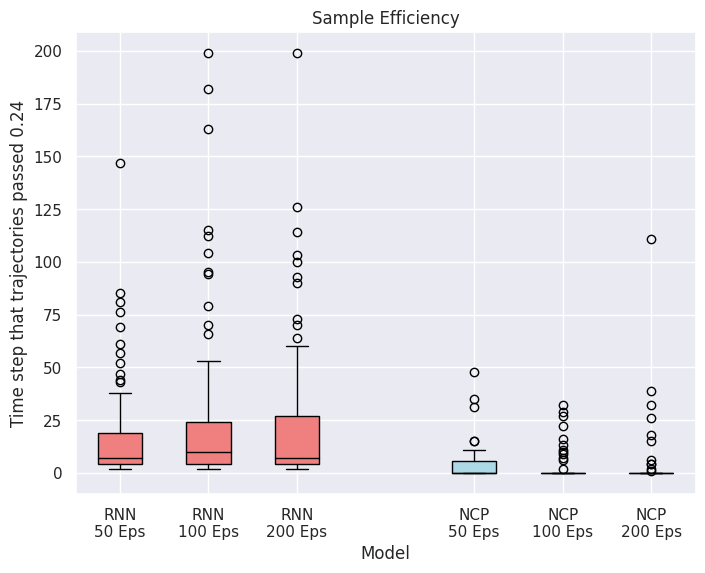

In [83]:
# Define positions for boxplots
x_positions_rnn = np.array([1, 2, 3])
x_positions_ncps = x_positions_rnn + 4
all_positions = np.concatenate([x_positions_rnn, x_positions_ncps])

# Create figure
plt.figure(figsize=(8, 6))

# Boxplots for Model 2
plt.boxplot(rnn_indices, positions=x_positions_rnn, widths=0.5, patch_artist=True, 
            boxprops=dict(facecolor="lightcoral"), medianprops=dict(color="black"))

# Boxplots for Model 2
plt.boxplot(ncps_indices, positions=x_positions_ncps, widths=0.5, patch_artist=True, 
            boxprops=dict(facecolor="lightblue"), medianprops=dict(color="black"))

# Labels and titles
labels = ["50 Eps", "100 Eps", "200 Eps"]
x_labels = [f"RNN\n{label}" for label in labels] + [f"NCP\n{label}" for label in labels]

print(len(x_labels), len(all_positions))

plt.xticks(all_positions, x_labels)
plt.xlabel("Model")
plt.ylabel(f"Time step that trajectories passed {threshold}")
plt.title("Sample Efficiency")

plt.show()


## Out of Distribution Testing with PPO Agent

In [84]:
from state_indep_ppo import PPO

agent = PPO(3, 1)
actor_path = "models/PPO_Actor"
critic_path = "models/PPO_Critic"
agent.actor.load_state_dict(torch.load(actor_path, weights_only=True))
agent.critic.load_state_dict(torch.load(critic_path, weights_only=True))

<All keys matched successfully>

In [85]:
angular_velocity = 2
max_angular_velocity_magnitude = 8

def agent_rollout(env, agent, n_iter):
    t_obs = []
    t_a = []
    t_n_obs = []
    for _ in range(50):
        observation, info = env.reset()
    
        terminated = False
        truncated = False

        c_obs = []
        c_a = []
        c_n_obs = []
    
        while not (terminated or truncated):
            # Get the action from the trained PPO agent
            obs = observation
            v_obs = torch.FloatTensor(observation)

            action, log_prob = agent.get_action(v_obs)
    
            # Take a step in the environment
            observation, reward, terminated, truncated, info = env.step(action)
        
            c_obs.append(obs)
            c_a.append(action)
            c_n_obs.append(observation)

        t_obs.append(np.vstack(c_obs))
        t_a.append(np.vstack(c_a))
        t_n_obs.append(np.vstack(c_n_obs))

    # Once the episode is done, close the environment
    env.close()

    t_obs = np.stack(t_obs)
    t_a = np.stack(t_a)
    t_n_obs = np.stack(t_n_obs)

    t_obs = t_obs[:,:,:2]

    states_actions = np.concatenate((t_obs, t_a), axis=2)
    states_actions = torch.from_numpy(states_actions).float()

    return states_actions

n_iter = 50
states_actions = agent_rollout(env, agent, n_iter)
states_actions.shape

torch.Size([50, 200, 3])

### RNN

In [86]:
horizon = 199

ood_rnn_preds = []
ood_rnn_sum_residuals = []
for i in range(len(num_episodes)):
    preds, states_actions = rnn_rollout(rnn_models[i], n_iter, horizon, states_actions)
    ood_rnn_preds.append(preds)

    residuals = states_actions[:, 1:horizon + 1, :2] - preds
    ood_rnn_sum_residuals.append(residuals.abs().sum(dim=2))

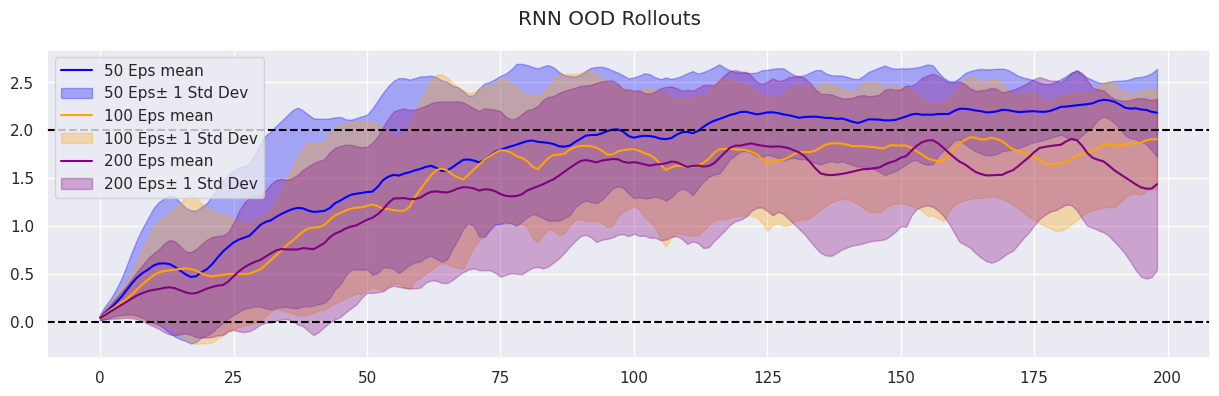

In [87]:
# Plot Rollouts
fig, axs = plt.subplots(1, 1, figsize=(15, 4))
fig.suptitle("RNN OOD Rollouts")

for i in range(len(num_episodes)):
    plot_feature_trajectory(axs, ood_rnn_sum_residuals[i], f"{num_episodes[i]} Eps", n_iter, horizon, colors[i], False)
axs.axhline(2, c="black", linestyle="dashed") # Dummy Line
axs.axhline(0, c="black", linestyle="dashed") # 0 Line

### NCPS

In [88]:
t_inputs = states_actions
ncps_sum_residuals = []
for i in range(3):
    model = ncps_models[i]
    preds = n_step_rollouts(model)
    NCPS_res = torch.tensor(preds - t_outputs[:, :, :2])
    NCPS_total_res = torch.sum(torch.abs(NCPS_res), axis=-1)
    ncps_sum_residuals.append(NCPS_total_res)

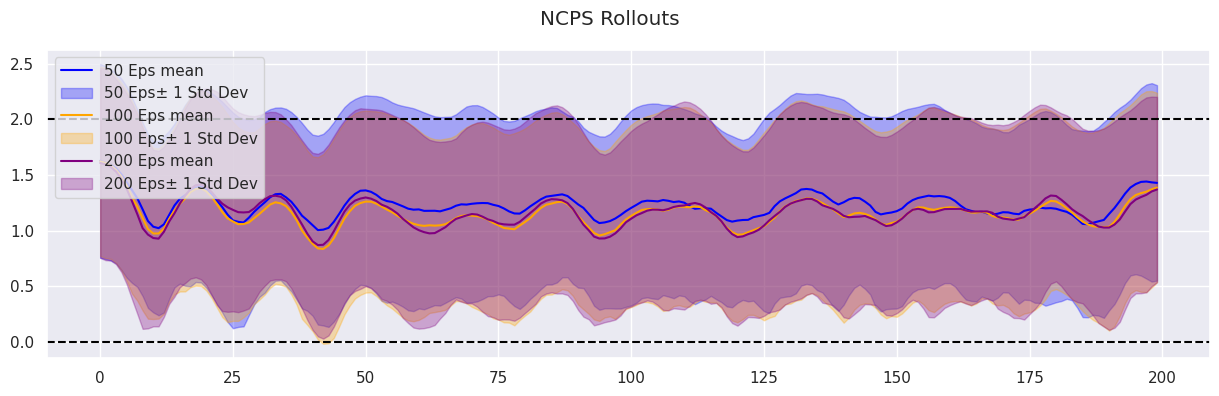

In [89]:
# Plot Rollouts
fig, axs = plt.subplots(1, 1, figsize=(15, 4))
fig.suptitle("NCPS Rollouts")

for i in range(len(num_episodes)):
    plot_feature_trajectory(axs, ncps_sum_residuals[i], f"{num_episodes[i]} Eps", n_iter, 200, colors[i], False)
axs.axhline(2, c="black", linestyle="dashed") # Dummy Line
axs.axhline(0, c="black", linestyle="dashed") # 0 Line

### Plot them all together

In [90]:
ood_rnn_indices = []
for i in range(len(num_episodes)):
    ood_rnn_indices.append(when_residuals_exceed_threshold(ood_rnn_sum_residuals[i], threshold))

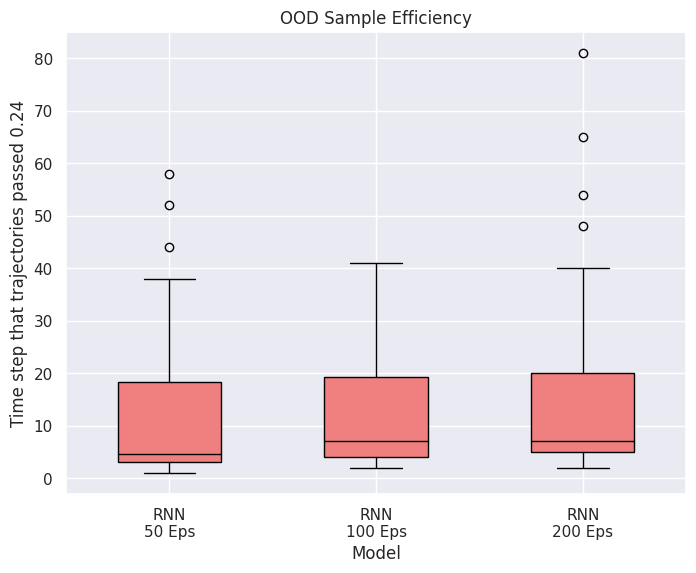

In [91]:
# Define positions for boxplots
x_positions_rnn = np.array([1, 2, 3])
# x_positions_ncps = x_positions_res + 8
# all_positions = np.concatenate([x_positions_res, x_positions_rnn, x_positions_ncps])

# Create figure
plt.figure(figsize=(8, 6))

# Boxplots for RNN
plt.boxplot(ood_rnn_indices, positions=x_positions_rnn, widths=0.5, patch_artist=True, 
            boxprops=dict(facecolor="lightcoral"), medianprops=dict(color="black"))

# Boxplots for NCPS
# plt.boxplot(ood_ncps_indices, positions=x_positions_ncps, widths=0.5, patch_artist=True, 
#             boxprops=dict(facecolor="lightgreen"), medianprops=dict(color="black"))

# Labels and titles
labels = ["50 Eps", "100 Eps", "200 Eps"]
x_labels = [f"RNN\n{label}" for label in labels] #+ \
    #[f"NCPS\n{label}" for label in labels]

plt.xticks(x_positions_rnn, x_labels)
plt.xlabel("Model")
plt.ylabel(f"Time step that trajectories passed {threshold}")
plt.title("OOD Sample Efficiency")

plt.show()
